# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
counts = np.array([8, 2])
total = counts.sum()

probs = counts / total

entropy = -np.sum(probs * np.log(probs))

print(f"Энтропия = {round(entropy, 2)}")

Энтропия = 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def entropy(counts):
    probs = counts / np.sum(counts)
    return -np.sum(probs * np.log(probs + 1e-10))


parent_counts = np.array([8, 2])
H_parent = entropy(parent_counts)

# энтропия левого поддерева
left_counts = np.array([4, 2])
H_left = entropy(left_counts)

# энтропия правого поддерева
right_counts = np.array([4, 0])
H_right = entropy(right_counts)

# веса поддеревьев
total = np.sum(parent_counts)
w_left = np.sum(left_counts) / total
w_right = np.sum(right_counts) / total

info_gain = H_parent - (w_left * H_left + w_right * H_right)

print(f"Информационный выигрыш = {round(info_gain, 2)}")

Информационный выигрыш = 0.12


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
y_leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

# предсказание модели есть среднее
prediction = np.mean(y_leaf)

print(f"Предсказание модели = {prediction}")

Предсказание модели = 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real",
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    x = np.array(feature_vector)
    y = np.array(target_vector)

    if np.all(x == x[0]):
        return np.array([]), np.array([]), None, None

    if feature_type == "real":
        sorted_idx = np.argsort(x)
        x_sorted = x[sorted_idx]
        y_sorted = y[sorted_idx]

        mask = np.diff(x_sorted) != 0
        thresholds = (x_sorted[:-1][mask] + x_sorted[1:][mask]) / 2

        left_masks = x_sorted[:, None] < thresholds
        right_masks = ~left_masks

        def calc_criterion(mask):
            if task == "regression":
                return np.var(y_sorted[mask], ddof=0) if np.any(mask) else 0.0
            elif task == "classification":
                classes = np.unique(y)
                probs = np.array([(y_sorted[mask] == c).mean() for c in classes])
                return 1.0 - np.sum(probs**2) if np.any(mask) else 0.0

        left_weights = left_masks.sum(axis=0)
        right_weights = right_masks.sum(axis=0)
        total = len(y)

        crit_left = np.array(
            [calc_criterion(left_masks[:, i]) for i in range(len(thresholds))]
        )
        crit_right = np.array(
            [calc_criterion(right_masks[:, i]) for i in range(len(thresholds))]
        )

        weighted_criterion = (
            left_weights * crit_left + right_weights * crit_right
        ) / total

        best_idx = np.argmin(weighted_criterion)
        best_threshold = thresholds[best_idx]
        best_criterion = weighted_criterion[best_idx]

        return thresholds, weighted_criterion, best_threshold, best_criterion

    elif feature_type == "categorical":
        values = np.unique(x)
        criteria = []
        thresholds = []

        for val in values:
            left_mask = x == val
            right_mask = x != val

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            if task == "regression":
                crit = (
                    np.var(y[left_mask], ddof=0) * np.sum(left_mask)
                    + np.var(y[right_mask], ddof=0) * np.sum(right_mask)
                ) / len(y)
            else:

                def gini(y_subset):
                    probs = np.array([(y_subset == c).mean() for c in np.unique(y)])
                    return 1.0 - np.sum(probs**2)

                crit = (
                    gini(y[left_mask]) * np.sum(left_mask)
                    + gini(y[right_mask]) * np.sum(right_mask)
                ) / len(y)

            thresholds.append(val)
            criteria.append(crit)

        if len(criteria) == 0:
            return np.array([]), np.array([]), None, None

        thresholds = np.array(thresholds)
        criteria = np.array(criteria)
        best_idx = np.argmin(criteria)
        return thresholds, criteria, thresholds[best_idx], criteria[best_idx]

    return np.array([]), np.array([]), None, None


# thresholds, variances, threshold_best, variance_best = find_best_split(
#     X["CRIM"].to_numpy(),
#     y,
#     task="regression",
#     feature_type="real"
# )

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [8]:
# !pip3 install scikit-learn==1.0.2

In [9]:
# # load_boston больше нет в sklearn.datasets :(

# from sklearn.datasets import load_boston

# boston = load_boston()
# X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
# y = boston["target"]
# X.head()

# print(boston["DESCR"])

In [10]:
import pandas as pd
import numpy as np

# выполним загрузку датасета boston вручную
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

column_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
]

boston = {
    "data": data,
    "target": target,
    "feature_names": column_names,
}

X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = pd.Series(boston["target"])

print(X.head())

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_129614/3841911354.py:6: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

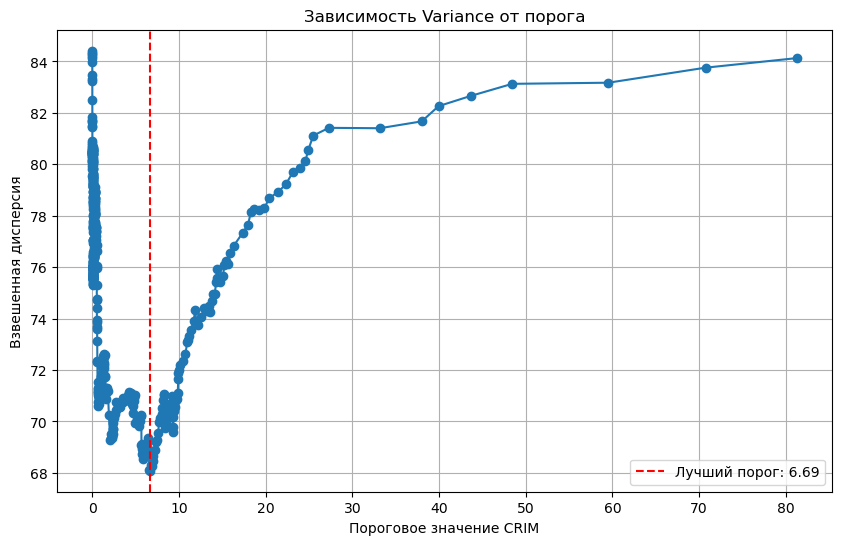

In [11]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), y, task="regression", feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, variances, marker="o")
plt.axvline(
    threshold_best,
    color="r",
    linestyle="--",
    label=f"Лучший порог: {threshold_best:.2f}",
)
plt.title("Зависимость Variance от порога")
plt.xlabel("Пороговое значение CRIM")
plt.ylabel("Взвешенная дисперсия")
plt.legend()
plt.grid(True)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [12]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification",
    ) -> None:

        if np.any([ft not in ("real", "categorical") for ft in feature_types]):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            feature_vector = sub_X[:, feature]

            _, _, threshold_tmp, gini_tmp = find_best_split(
                feature_vector, sub_y, self.task, feature_type
            )

            if threshold_tmp is None or gini_tmp is None:
                continue

            if gini_best is None or gini_tmp > gini_best:
                feature_best = feature
                gini_best = gini_tmp
                threshold_best = threshold_tmp

                if feature_type == "real":
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            if x[feature_idx] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_node(x, self._tree) for x in X])

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

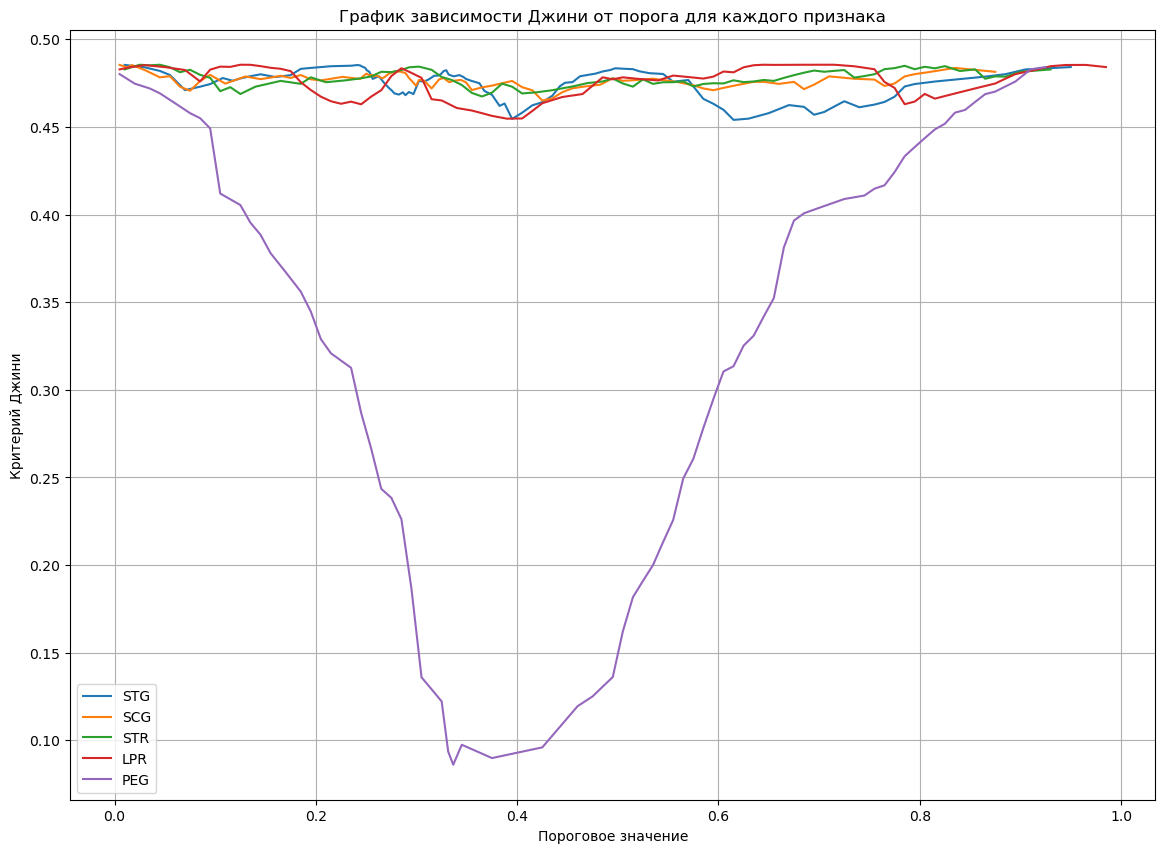

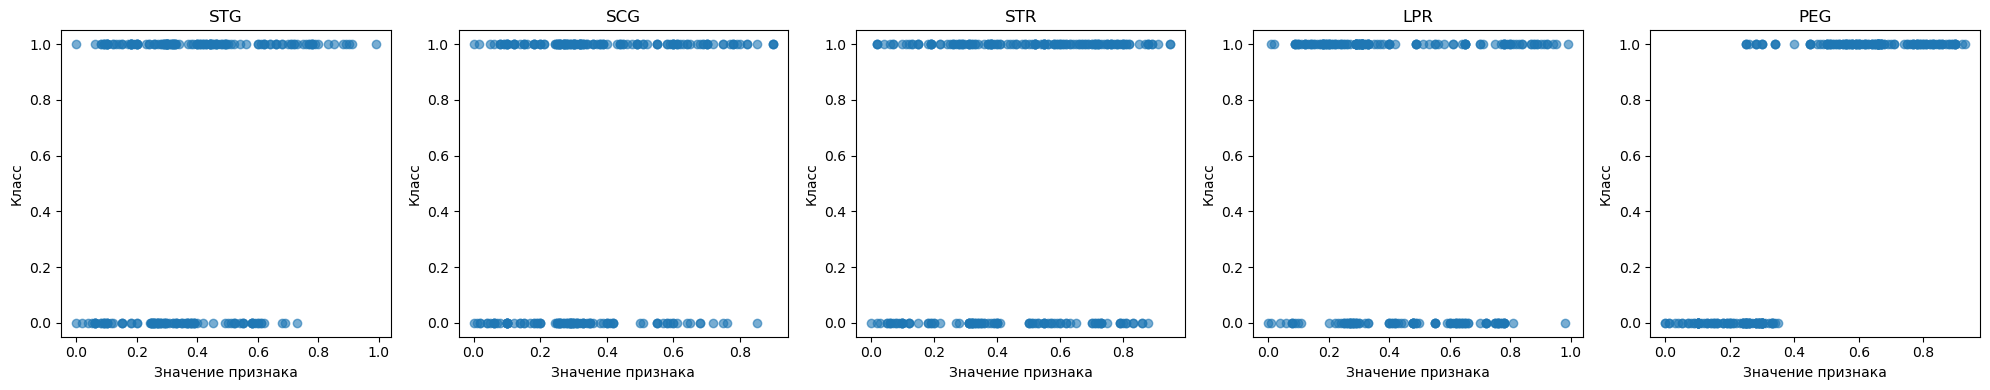

In [13]:
df = pd.read_csv("students.csv")
df = df.loc[:, df.columns != "Unnamed: 0"]

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

feature_names = X.columns
n_features = X.shape[1]

plt.figure(figsize=(14, 10))
for i, feature in enumerate(feature_names):
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        X[feature].to_numpy(), y.to_numpy(), task="classification", feature_type="real"
    )
    plt.plot(thresholds, ginis, label=f"{feature}")

plt.xlabel("Пороговое значение")
plt.ylabel("Критерий Джини")
plt.title("График зависимости Джини от порога для каждого признака")
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(20, 4))
for i, feature in enumerate(feature_names):
    axes[i].scatter(X[feature], y, alpha=0.6)
    axes[i].set_title(feature)
    axes[i].set_xlabel("Значение признака")
    axes[i].set_ylabel("Класс")
plt.tight_layout()
plt.show()

Делаем вывод, что признак PEG - наиболее информативный.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

column_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]
df = pd.read_csv("agaricus-lepiota.data", header=None, names=column_names)

encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop("class", axis=1).values
y = df["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

feature_types = ["categorical"] * X.shape[1]

# обучим наше дерево
tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy = {round(acc, 4)}")

Accuracy = 0.9934


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
data = pd.read_csv("diabetes.csv")
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

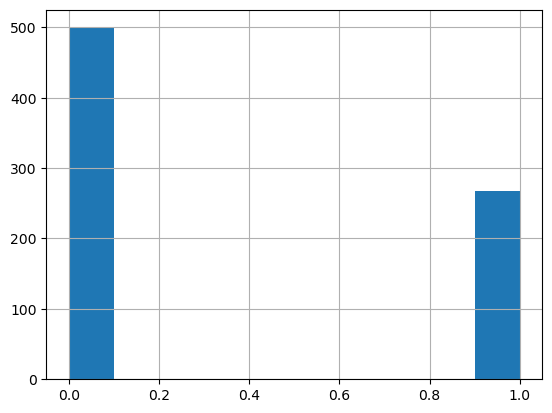

In [17]:
data["Outcome"].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [18]:
X = data.drop(columns="Outcome")
y = data["Outcome"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)


def print_shape(name, X_part):
    percent = len(X_part) / len(data) * 100
    print(f"{name}: {X_part.shape[0]} ({round(percent, 2)}%)")


print_shape("train", X_train)
print_shape("valid", X_val)
print_shape("test", X_test)

train: 375 (48.83%)
valid: 162 (21.09%)
test: 231 (30.08%)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [19]:
import itertools
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

max_depth_values = [2, 4, 6, 8, 10, None]
min_samples_leaf_values = [1, 5, 10, 20]

best_f1 = 0
best_params = None

# поиск лучшей пары параметров
for max_depth, min_samples_leaf in itertools.product(
    max_depth_values, min_samples_leaf_values
):
    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42
    )
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_params = (max_depth, min_samples_leaf)

X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

clf_final = DecisionTreeClassifier(
    max_depth=best_params[0], min_samples_leaf=best_params[1], random_state=42
)
clf_final.fit(X_full_train, y_full_train)

y_test_pred = clf_final.predict(X_test)
y_test_proba = clf_final.predict_proba(X_test)[:, 1]

# метрики
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_proba)

print(f"best params: max_depth = {best_params[0]}, min_samples_leaf = {best_params[1]}")
print(f"valid F1: {round(best_f1, 4)}")
print(f"test Accuracy: {round(acc, 4)}")
print(f"test Precision: {round(prec, 4)}")
print(f"test Recall: {round(rec, 4)}")
print(f"test AUC-ROC: {round(auc, 4)}")

best params: max_depth = 6, min_samples_leaf = 20
valid F1: 0.625
test Accuracy: 0.7489
test Precision: 0.6667
test Recall: 0.5679
test AUC-ROC: 0.7967


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1,
)

bagging_clf.fit(X_full_train, y_full_train)

y_bag_pred = bagging_clf.predict(X_test)
y_bag_proba = bagging_clf.predict_proba(X_test)[:, 1]

# метрики
acc_bag = accuracy_score(y_test, y_bag_pred)
prec_bag = precision_score(y_test, y_bag_pred)
rec_bag = recall_score(y_test, y_bag_pred)
auc_bag = roc_auc_score(y_test, y_bag_proba)

print("BaggingClassifier (50 trees):")
print(f"Accuracy = {round(acc_bag, 2)}")
print(f"Precision = {round(prec_bag, 2)}")
print(f"Recall = {round(rec_bag, 2)}")
print(f"AUC-ROC = {round(auc_bag, 2)}")

BaggingClassifier (50 trees):
Accuracy = 0.74
Precision = 0.67
Recall = 0.53
AUC-ROC = 0.82


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
)
import itertools

# гиперпараметры для подбора
max_depth_values = [4, 6, 8, 10, None]
min_samples_split_values = [2, 5, 10]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1_cv = 0
best_params_cv = None

# перебор всех комбинаций
for max_depth, min_samples_split in itertools.product(
    max_depth_values, min_samples_split_values
):
    rf = RandomForestClassifier(
        n_estimators=50,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1,
    )

    f1_scores = cross_val_score(rf, X_full_train, y_full_train, cv=cv, scoring="f1")
    mean_f1 = f1_scores.mean()

    if mean_f1 > best_f1_cv:
        best_f1_cv = mean_f1
        best_params_cv = (max_depth, min_samples_split)

best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_cv[0],
    min_samples_split=best_params_cv[1],
    random_state=42,
    n_jobs=-1,
)
best_rf.fit(X_full_train, y_full_train)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# метрики
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("🎯 Random Forest (50 trees)")
print(
    f"Best params: max_depth = {best_params_cv[0]}, min_samples_split = {best_params_cv[1]}"
)
print(f"F1: {round(f1_rf, 4)}")
print(f"Accuracy: {round(acc_rf, 4)}")
print(f"Precision: {round(prec_rf, 4)}")
print(f"Recall: {round(rec_rf, 4)}")
print(f"AUC-ROC: {round(auc_rf, 4)}")

🎯 Random Forest (50 trees)
Best params: max_depth = 10, min_samples_split = 10
F1: 0.5931
Accuracy: 0.7446
Precision: 0.6719
Recall: 0.5309
AUC-ROC: 0.8297


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

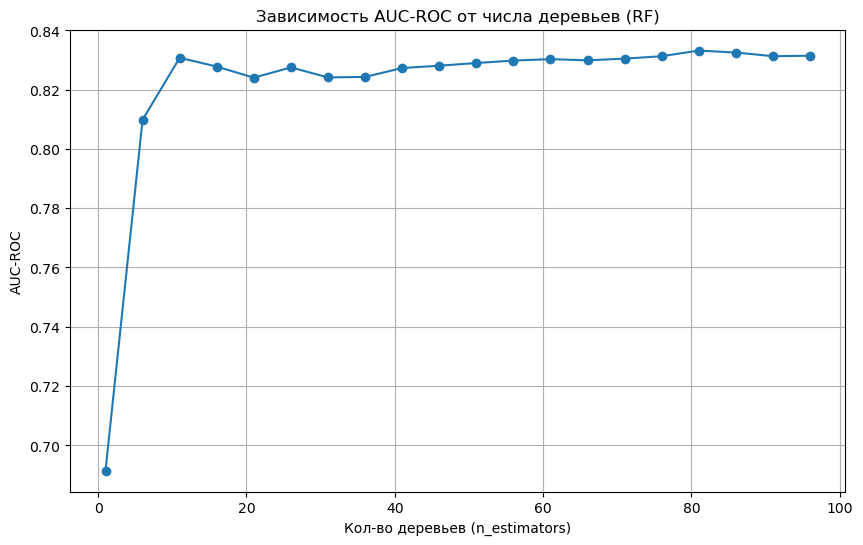

In [22]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# диапазон количества деревьев
n_estimators_range = range(1, 101, 5)
auc_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params_cv[0],
        min_samples_split=best_params_cv[1],
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_full_train, y_full_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, marker="o")
plt.xlabel("Кол-во деревьев (n_estimators)")
plt.ylabel("AUC-ROC")
plt.title("Зависимость AUC-ROC от числа деревьев (RF)")
plt.grid(True)
plt.show()

Выводы (задание 3.5):
- оптимальное число деревьев для баланса между качеством и скоростью $\approx$ 20-25;
- после $\approx$ 50 деревьев метрика стабилизируется.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

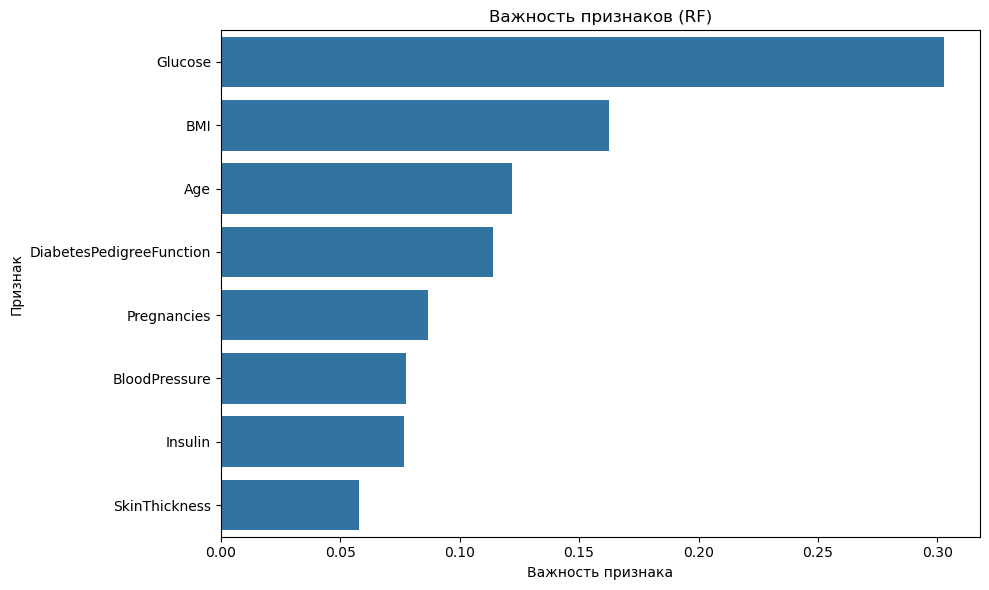

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# важность каждого признака
importances = best_rf.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков (RF)")
plt.tight_layout()
plt.show()

Выводы (задание 3.6)

- Glucose — самый значимый (более 30% общей важности), что логично;
- Pregnancies, BloodPressure, Insulin, SkinThickness — оказались наименее информативными.